<a href="https://colab.research.google.com/github/mr-alamdari/Generative-Adversarial-Networks-Pytorch/blob/main/Generative_Adversarial_Networks_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import os
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torchvision
import torchsummary

#1.Data

In [4]:
path2data = '/content/data'
os.makedirs(path2data, exist_ok=True)

In [5]:
h, w = 64, 64
mean = (0.485, 0.456, 0.406)
std = (0.5, 0.5, 0.5)
transform = torchvision.transforms.Compose([
            torchvision.transforms.Resize((h, w)),
            torchvision.transforms.CenterCrop((h, w)),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(mean, std)])

In [6]:
from torchvision.transforms import transforms
train_ds = torchvision.datasets.STL10(path2data,
                                      split='train',
                                      download=True,
                                      transform=transform)

  0%|          | 0/2640397119 [00:00<?, ?it/s]

Extracting /content/data/stl10_binary.tar.gz to /content/data


In [7]:
for x, _ in train_ds:
  print(x.shape, torch.min(x), torch.max(x))
  break

torch.Size([3, 64, 64]) tensor(-0.7975) tensor(1.0253)


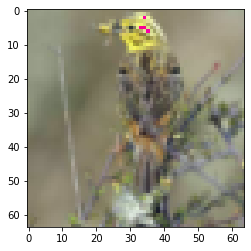

In [8]:
plt.imshow(torchvision.transforms.functional.to_pil_image(0.5*x + 0.5))

In [9]:
# If you run into memory errors when training a model, try reducing the batch size.
train_dl = torch.utils.data.DataLoader(train_ds, 
                                   batch_size=32, 
                                   shuffle=True)

In [10]:
for x, y in train_dl:
  print(x.shape, y.shape)
  break

torch.Size([32, 3, 64, 64]) torch.Size([32])


#2.Generator & Discriminator

###The GAN framework is based on the competition of two models, namely, the generator and discriminator.
#####The generator generates fake images and the discriminator tries to identify real images from fakes images.
###As a result of this competition, the generator will generate better-looking fake images while the discriminator will become better at identifying them.

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

##Generator

In [16]:
class Generator(torch.nn.Module):
  
  def __init__(self, params):
    super(Generator, self).__init__()
    nz = params['nz']
    ngf = params['ngf']
    noc = params['noc']

    self.dconv1 = torch.nn.ConvTranspose2d(nz, ngf*8, kernel_size=4, stride=1, padding=0, bias=False)
    self.bn1 = torch.nn.BatchNorm2d(ngf*8)
    
    self.dconv2 = torch.nn.ConvTranspose2d(ngf*8, ngf*4, kernel_size=4, stride=2, padding=1, bias=False)
    self.bn2 = torch.nn.BatchNorm2d(ngf*4)
    
    self.dconv3 = torch.nn.ConvTranspose2d(ngf*4, ngf*2, kernel_size=4, stride=2, padding=1, bias=False)
    self.bn3 = torch.nn.BatchNorm2d(ngf*2)
    
    self.dconv4 = torch.nn.ConvTranspose2d(ngf*2, ngf, kernel_size=4, stride=2, padding=1, bias=False)
    self.bn4 = torch.nn.BatchNorm2d(ngf)

    self.dconv5 = torch.nn.ConvTranspose2d(ngf, noc, kernel_size=4, stride=2, padding=1, bias=False)

  def forward(self, x):
    x = self.dconv1(x)
    x = self.bn1(x)
    x = torch.nn.functional.relu(x)

    x = self.dconv2(x)
    x = self.bn2(x)
    x = torch.nn.functional.relu(x)

    x = self.dconv3(x)
    x = self.bn3(x)
    x = torch.nn.functional.relu(x)

    x = self.dconv4(x)
    x = self.bn4(x)
    x = torch.nn.functional.relu(x)

    x = self.dconv5(x)
    x = torch.tanh(x)

    return x

In [17]:
params_gen = {'nz': 100, 'ngf': 64, 'noc':3}

model_gen = Generator(params_gen)
model_gen = model_gen.to(device)

In [18]:
print(model_gen)

Generator(
  (dconv1): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dconv2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dconv3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dconv4): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dconv5): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
)


In [19]:
with torch.no_grad():
  r = model_gen(torch.zeros(1, 100, 1, 1, device=device))
print(r.shape)

torch.Size([1, 3, 64, 64])
